# Setup

### Path setup

In [1]:
import os

In [2]:
path_to_this_folder = os.getcwd() # Do it before calling %cd ../.. so that the path is accurate

### Project setup

In [3]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"   # Prevent internal ngsolve imports from killing the kernel


In [4]:
%cd ../..
!pip install .
!pip install meshio
!pip install ngsolve




c:\Users\octav\Documents\GitHub\Stage_ARIA
Processing c:\users\octav\documents\github\stage_aria
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for yourpkg: filename=yourpkg-0.1.0-py3-none-any.whl size=39613 sha256=30a083aea8d8a0546617c4d469e44aa7d3282ba267a0c7db6a0da9e9e2f742f5
  Stored in directory: C:\Users\octav\AppData\Local\Temp\pip-ephem-wheel-cache-b7oje5hr\wheels\2f\97\6f\4cd56f403f3905a3673325538741a3519ba70ae59cdd7d492e
Successfully built yourpkg
  Attempting uninstall: yourpkg
    Found existing installation: yourpkg 0.1.0
    Uninstalling yourpkg-0.1.0:
      Successfully uninstalled yourpkg-0.1.0


### Imports

Usual libraries

In [5]:
import tomllib
from time import time
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np


Custom code

In [6]:
from src.Pre_processing.process_hardware import get_precision, get_device
from src.Pre_processing.process_gmsh import read_gmsh, get_nodes_and_elements_IDs
from src.FENN.VertexNN.FEENN_2D.FEENN import FEENN_2D
from src.FENN.VertexNN.FEENN_2D.Element import Tri_2D_lin
from src.FENN.VertexNN.FEENN_2D.Mapping import Mapping_2D_Affine
from src.FENN.ConstantNN.constantNN import ConstantNN
from src.FENN.L2NN.field_L2NN import Field_L2NN
from src.PropertiesNN.PropertiesNN import PropertiesNN
from src.Pre_processing.build_solver import build_solver
from src.PDE.optim_2D import Optim_2D_loss
from src.PDE.operators import curl
from src.PDE.magnetostatic_2D import Magnetostatic_2D
from src.MaterialNN.BinarySelection import BinarySelection
from src.Baselines.Poisson_2D.Uniform.baseline import baseline
from src.Post_processing.VTKExport.export_vtk import export_vtk
from src.MaterialNN.NL_nu import NL_nu
from src.PDE.magnetostatic_2D_NL import Magnetostatic_2D_NL



### Number precision

In [7]:
IntPrecision = torch.int32
FloatPrecision = torch.float64

### Hardware

Note that for cases of small meshes cpu outperforms gpu

In [8]:
device = 'cpu'

# Problem description and problem-related variables definition

$$
\begin{align*}
        \;&\text{Find }&&\overrightarrow{A}^* =\arg\min_{\overrightarrow{A}\in H\left(\overrightarrow{\text{rot}},\Omega\right)}\int_\Omega \frac{1}{2\mu(x, \overrightarrow{\text{curl}}(\overrightarrow{A}))}\cdot\overrightarrow{\text{curl}}\left(\overrightarrow{A}\right)\cdot\overrightarrow{\text{curl}}\left(\overrightarrow{A}\right)-\overrightarrow{j}\cdot\overrightarrow{A}\text{d}\Omega\\\\
        &\text{s.t}&&\overrightarrow{A}(x^+)\cdot \overrightarrow{e}_z=A_0\\
        &&&\overrightarrow{A}(x^-)\cdot \overrightarrow{e}_z = -A_0\\
        &&&\overrightarrow{A}(x) = \overrightarrow{0}&\forall x\in\partial \Omega\\
        &&&\mu(x) = \mu_0(\overrightarrow{\text{curl}}(\overrightarrow{A}))&\forall x\in \Omega \backslash \Omega^+\bigcup\Omega^-\\
        &&&\mu(x) = \mu_1(\overrightarrow{\text{curl}}(\overrightarrow{A}))&\forall x\in\Omega^+\bigcup\Omega^-\\
        &&&\overrightarrow{j}(x) = \overrightarrow{0}&\forall x\in \Omega\\
        
    \end{align*}
$$

$$
\nu_i(\overrightarrow{\text{curl}}(\overrightarrow{A})) = \nu_{i_0}+K_i\exp\left\{k_i\cdot \overrightarrow{\text{curl}}(\overrightarrow{A})\cdot \overrightarrow{\text{curl}}(\overrightarrow{A})\right\}
$$

$\Omega$ is defined through a .msh file

In [9]:
path_to_msh = os.path.join(path_to_this_folder, "Coil.msh")
# path_to_msh = os.path.join(path_to_this_folder, "Coil_fine.msh")
# path_to_msh = os.path.join(path_to_this_folder, "Coil_interm.msh")

$\mu$ can have two values $\mu_0$ or $\mu_1$ depending on the location in $\Omega$.  
For conveniency 
- we use $\nu = \frac{1}{\mu}$
- we enforce the switch between $\nu_0$ and $\nu_1$ through a choice field $p:\Omega\to\{0,1\}$ such that
$$
\nu(x) = (1-p(x))\nu_0 +p(x)\nu_1
$$

In [ ]:
# nu_0_value = 1/(4*np.pi*1e-7)
nu_0_value = 1

nu_10_value = nu_0_value*100 
K_1_value = nu_0_value*10 
k_1_value = 1.8 



No source term because $\overrightarrow{j} = \overrightarrow{0}$ in $\Omega$.

The problem is set in 2D

In [11]:
interior_dim = 2
boundary_dim = 1

$\overrightarrow{A}$ is a vector field that can be represented as a scalar field carried by $\overrightarrow{e}_z$. Hence only one component is necessary to identify $\overrightarrow{A}$.

In [12]:
n_components = 1

dirichlet_exterior = {'entity_name'         : 'Exterior',
                        'Value'              : 0}

dirichlet_positive_source = {'entity_name'                       : 'Positive_source',
                            'entity_dim'                         : 0,
                            'Value'                              : 1 }

dirichlet_negative_source = {'entity_name'                       : 'Negative_source',
                            'entity_dim'                         : 0,
                            'Value'                              : -1}

dirichlet_config = [dirichlet_exterior, dirichlet_positive_source, dirichlet_negative_source]

We use a linear interpolation for our FEM representation of $V$. Therefore $\overrightarrow{\text{curl}}(\overrightarrow{A})$ is constant by element and the appropriate integration scheme is an order 1 gaussian quadrature.

In [13]:
quadrature_order = 1

# Baseline with NGSolve

Solve the problem with NGSolve to get a baseline.

Fore more info, see : https://docu.ngsolve.org/latest/

In [14]:
# todo

# FENN solve

Read the gmsh file and get the mesh related info

In [15]:
gmsh_mesh = read_gmsh(path_to_msh = path_to_msh,
                      IntPrecision = IntPrecision,
                      FloatPrecision = FloatPrecision)

Nodes = gmsh_mesh.nodes
connectivity = gmsh_mesh.elements[str(interior_dim)]['connectivity']

Processing GMSH file: 100%|██████████| 1203/1203 [00:00<00:00, 478179.28it/s]


Build a field candidate

In [16]:
# Build the field candidate. Here we use a linear interpolation scheme.
A = FEENN_2D(Nodes = Nodes,
            connectivity=connectivity,
            n_components=1,
            element=Tri_2D_lin(IntPrecision=IntPrecision, FloatPrecision=FloatPrecision),
            mapping = Mapping_2D_Affine(),
            IntPrecision=IntPrecision,
            FloatPrecision=FloatPrecision)

# Apply dirichlet
for dirichlet in dirichlet_config:

    nodeIDs, _ = get_nodes_and_elements_IDs(gmsh_mesh=gmsh_mesh,
                                            entity_dim = dirichlet.get('entity_dim', 1),
                                            entity_name = dirichlet.get('entity_name', None),
                                            entity_tag = dirichlet.get('entity_tag', None))
    
    
    value = dirichlet['Value']*torch.ones_like(nodeIDs, dtype = FloatPrecision).unsqueeze(-1)

    A.SetBCs(Fixed_nodal_coordinates_Ids = nodeIDs,
            Fixed_nodal_values_Ids = nodeIDs,
            Fixed_nodal_values_values = value)
    

# Specify the integration scheme
A.SetQuad(quadrature_order = quadrature_order)
A.Freeze(freeze_grid=True, freeze_interpolation=False)

# Move the object to the chosen hardware
A.to(device)

# Specify that A should store its evolution so that we can export it to vtk
A.StoreResults()

c:\Users\octav\Documents\GitHub\Stage_ARIA\src\FENN\VertexNN\FEENN_2D\FEENN.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer('connectivity', torch.tensor(connectivity, dtype = self.ref_int.dtype))


Define the material.

In [17]:
# Define the nu_0 property
# nu_0 = NL_nu(nu_0 = nu_00_value, 
#             K = K_0_value, 
#             k = k_0_value,
#             IntPrecision = IntPrecision,
#             FloatPrecision = FloatPrecision)

# Define the nu_0 property
nu_0 = ConstantNN(property_value=nu_0_value,
                    IntPrecision = IntPrecision,
                    FloatPrecision = FloatPrecision)

# nu_0 is not a field to be found
nu_0.setBCs(is_fixed=True)

# Define the nu_1 property
nu_1 = NL_nu(nu_0 = nu_10_value, 
            K = K_1_value, 
            k = k_1_value,
            IntPrecision = IntPrecision,
            FloatPrecision = FloatPrecision)

# nu_1 is not a field to be found
nu_1.setBCs(is_fixed=True)


# Define the nu property using nu_0 and nu_1
# BinarySelection.forward(el_ids, NPoints, *args, **kwargs) -> (1-choice)*self.properties['property_1'](el_ids, NPoints, *args, **kwargs) + choice*self.properties['property_2'](el_ids, NPoints, *args, **kwargs)
nu = BinarySelection(property_1     = nu_0,
                    property_2     = nu_1,
                    NElem          = len(connectivity),
                    IntPrecision   = IntPrecision,
                    FloatPrecision = FloatPrecision)

# Set the value of nu to nu_0 in "domain_no_coil"
# BinarySelection.setBCs <=> select and fix the value of the "choice" variable (see BinarySelection.forward)
_, elemIDs = get_nodes_and_elements_IDs(gmsh_mesh=gmsh_mesh,
                                            entity_dim=2,
                                            entity_name = 'domain_no_coil')

nu.setBCs(Fixed_Ids=elemIDs, specific_value=torch.zeros_like(elemIDs))

# Set the value of nu to nu_1 in "coil_1"
# BinarySelection.setBCs <=> select and fix the value of the "choice" variable (see BinarySelection.forward)
_, elemIDs = get_nodes_and_elements_IDs(gmsh_mesh=gmsh_mesh,
                                            entity_dim=2,
                                            entity_name = 'coil_1')

nu.setBCs(Fixed_Ids=elemIDs, specific_value=torch.ones_like(elemIDs))

# Set the value of nu to nu_1 in "coil_2"
# BinarySelection.setBCs <=> select and fix the value of the "choice" variable (see BinarySelection.forward)
_, elemIDs = get_nodes_and_elements_IDs(gmsh_mesh=gmsh_mesh,
                                            entity_dim=2,
                                            entity_name = 'coil_2')

nu.setBCs(Fixed_Ids=elemIDs, specific_value=torch.ones_like(elemIDs))

# The only problem-relevant material property is nu
Mat = PropertiesNN(dim = interior_dim,
                NElem = len(connectivity),
                IntPrecision = IntPrecision,
                FloatPrecision = FloatPrecision)

Mat.add_property(property_name = 'nu',
                property = nu)

# Move the object to the chosen hardware
Mat.to(device)

PropertiesNN(
  (properties): ModuleDict(
    (nu): BinarySelection(
      (soft_choice): ParameterDict(
          (free): Parameter containing: [torch.DoubleTensor of size 0]
          (imposed): Parameter containing: [torch.DoubleTensor of size 748]
      )
      (properties): ModuleDict(
        (property_1): ConstantNN()
        (property_2): NL_nu(
          (nu_0): ConstantNN()
          (K): ConstantNN()
          (k): ConstantNN()
        )
      )
      (sigmoid): Sigmoid()
    )
  )
)

Define the objective function and how the fields of interest should be saved

In [18]:
vtk_export_config = {'path_to_folder'       : os.path.join(os.path.join(path_to_this_folder, 'Results'), 'VTK_exports'),
                    'cell_data'             : ['B', 'potential', 'j', 'field_term', 'source_term', 'nu', 'mapping_det'],
                    'point_data'            : ['A'],
                    'export_vtk'            : True}

energy_functionnal = Magnetostatic_2D_NL(IntPrecision=IntPrecision, 
                                        FloatPrecision=FloatPrecision,
                                        vtk_export = vtk_export_config,
                                        #baseline = baseline,                       todo
                                        # baseline_mesh = baseline_mesh,            todo
                                        )

Specify the solver and build it. Here, the objective is convex so LBFGS (quasi-Newton) is appropriate.

In [19]:
solver_config = {'optimizer'               :  'lbfgs',
            'n_epochs'                :  5000,
            'loss_decrease_c'         :   1e-13,
            'freeze_grid'             :   True,
            'freeze_interpolation'    :   False,
            'freeze_Mat'              :   True}

solver = build_solver(solver_config = solver_config,
                      loss = energy_functionnal,
                      model = A,
                      Mat = Mat)

solver.solve()

Solving (worse case scenario):   0%|          | 1/5000 [00:00<?, ?it/s, time=0]

ValueError: Loss is nan

Export the loss

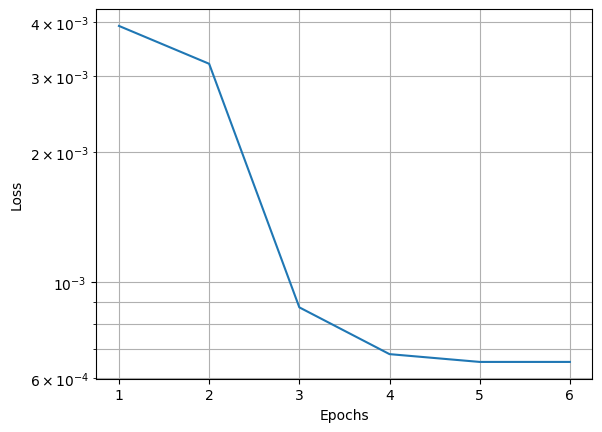

In [ ]:
epochs, loss = solver.get_metric()

# Define the path to the main plot save folder
save_folder = os.path.join(os.path.join(path_to_this_folder, 'Results'), 'Plots')
os.makedirs(save_folder, exist_ok=True)

# Plot and save the loss evolution
save_name = f"loss.png"
save_path = os.path.join(save_folder, save_name)
plt.clf()
plt.plot(epochs, loss)
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True, which='both')
plt.savefig(save_path)

In [ ]:
loss

[array(0.00391898),
 array(0.00320331),
 array(0.00087528),
 array(0.00068225),
 array(0.00065451),
 array(0.00065451)]

See the results in the VTK file